In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
import networkx as nx
import matplotlib.pyplot as plt
import shap
from causal_inference import CausalInference
from evaluation import iterative_feature_deletion_with_avg_output_regression, iterative_feature_addition_with_avg_output_regression

import warnings
warnings.filterwarnings("ignore")


c:\Users\snorl\Desktop\FYP\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(42)
n_samples = 1000
sigma = 0.1

A = np.random.normal(0, 1, n_samples)

epsilon_1 = np.random.normal(0, sigma, n_samples)
epsilon_2 = np.random.normal(0, sigma, n_samples)
epsilon_3 = np.random.normal(0, sigma, n_samples)
epsilon_4 = np.random.normal(0, sigma, n_samples)

B = 2 * A + epsilon_1
C = -1.5 * A + epsilon_2
D = 0.9 * B + 0.3 * C + epsilon_3
E = 1.2 * D + epsilon_4

data = pd.DataFrame({'A': A, 'B': B, 'C': C, 'D': D, 'E': E})


In [3]:
X = data[['A', 'B', 'C', 'D']]
y = data['E']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
model.fit(X_train_scaled_df, y_train)



SVR()

100%|██████████| 200/200 [00:14<00:00, 13.51it/s]


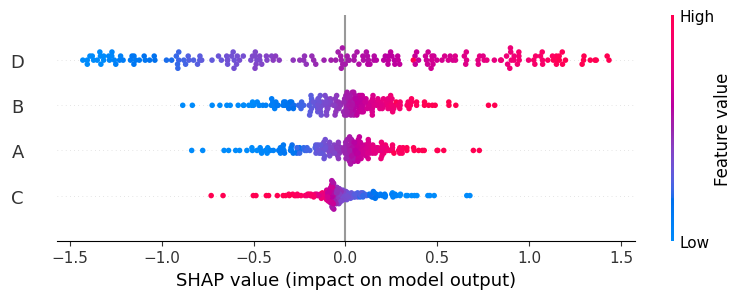

In [4]:
background_data = shap.kmeans(X_train_scaled, 100)

explainer = shap.KernelExplainer(model.predict, background_data)
shap_values = explainer.shap_values(X_test_scaled)

shap.summary_plot(shap_values, X_test)


In [18]:
# Good Result: 10
i = 3

print(f"SHAP values for test instance {i}:")
print(shap_values[i])

shap_sum = np.sum(shap_values[i]) + explainer.expected_value
print(f"Expected value for instance {i}: {explainer.expected_value}")
print(f"Sum of SHAP values + expected value for instance {i}: {shap_sum}")

model_prediction = model.predict(X_test_scaled[i].reshape(1, -1))[0]
print(f"Model prediction for test instance {i}: {model_prediction}")

actual_value = y_test.iloc[i]
print(f"Actual target value for test instance {i}: {actual_value}")

if np.isclose(shap_sum, model_prediction, atol=1e-6):
    print("The sum of SHAP values and the expected value matches the model prediction.")
else:
    print("There is a discrepancy between the SHAP sum and the model prediction.")

SHAP values for test instance 3:
[-0.11857525 -0.13061239 -0.07961259 -0.58922518]
Expected value for instance 3: 0.04572461797986535
Sum of SHAP values + expected value for instance 3: -0.8723007895612214
Model prediction for test instance 3: -0.8723007895612214
Actual target value for test instance 3: -0.7244140650829565
The sum of SHAP values and the expected value matches the model prediction.


In [19]:
target_variable = 'E'  

# Ensure that y_test is reset to have a sequential index
y_test = y_test.reset_index(drop=True)
# Ensure that y_train is reset to have a sequential index
y_train = y_train.reset_index(drop=True)

# Combine features and target variable into one DataFrame
data_with_E = pd.concat([X_train_scaled_df, y_train], axis=1)
data_with_E = data_with_E.rename(columns={0: 'E'})

# Create an instance of CausalInference with data including 'E'
ci = CausalInference(data=data_with_E, model=model, target_variable=target_variable)

# Load causal strengths from JSON file
ci.load_causal_strengths('../../../Result/R/Mean_Causal_Effect_Synthetic.json')

# Prepare the instance to explain (ensure it's a Series with feature names)
x_instance = pd.Series(X_test_scaled_df.iloc[i], index=X_test_scaled_df.columns)

# Compute the modified SHAP values
phi_normalized = ci.compute_modified_shap(x_instance)

# Output the modified SHAP values
print("Modified Causal SHAP Values:")
for feature, value in phi_normalized.items():
    print(f"{feature}: {value}")


Modified Causal SHAP Values:
A: -0.6035421882194453
B: -0.13887534737696752
C: -0.006143785208494465
D: -0.16930910260861504


In [28]:
shap_totals = {feature: 0 for feature in X_test_scaled_df.columns}
for i in range(len(X_test)):
    x_instance = pd.Series(X_test_scaled_df.iloc[i], index=X_test_scaled_df.columns)
    phi_normalized = ci.compute_modified_shap(x_instance)
    for feature, value in phi_normalized.items():
            shap_totals[feature] += abs(value)

# Compute the average SHAP values by dividing the totals by the number of test instances
num_instances = len(X_test)
shap_averages = {feature: total / num_instances for feature, total in shap_totals.items()}

# Output the average SHAP values
print("Average Modified Causal SHAP Values:")
for feature, avg_value in shap_averages.items():
    print(f"{feature}: {avg_value}")

Average Modified Causal SHAP Values:
A: 0.8648962302333346
B: 0.163457329575121
C: 0.011410457449253585
D: 0.19580967461132978


In [25]:
shap_values = explainer.shap_values(X_test_scaled)

# Summing the absolute SHAP values for each feature across all instances
feature_importance = np.mean(np.abs(shap_values), axis=0)

print(feature_importance)


100%|██████████| 200/200 [00:13<00:00, 15.16it/s]


[0.18780112 0.21474301 0.13434717 0.7007943 ]


In [20]:
print(f"True Causal Effect: {ci.gamma}")

True Causal Effect: {'A': 0.5113400716934026, 'B': 0.1733695236846662, 'C': 0.10981154145323135, 'D': 0.20547886316869995, 'E': 0.0}


<Figure size 1000x600 with 0 Axes>

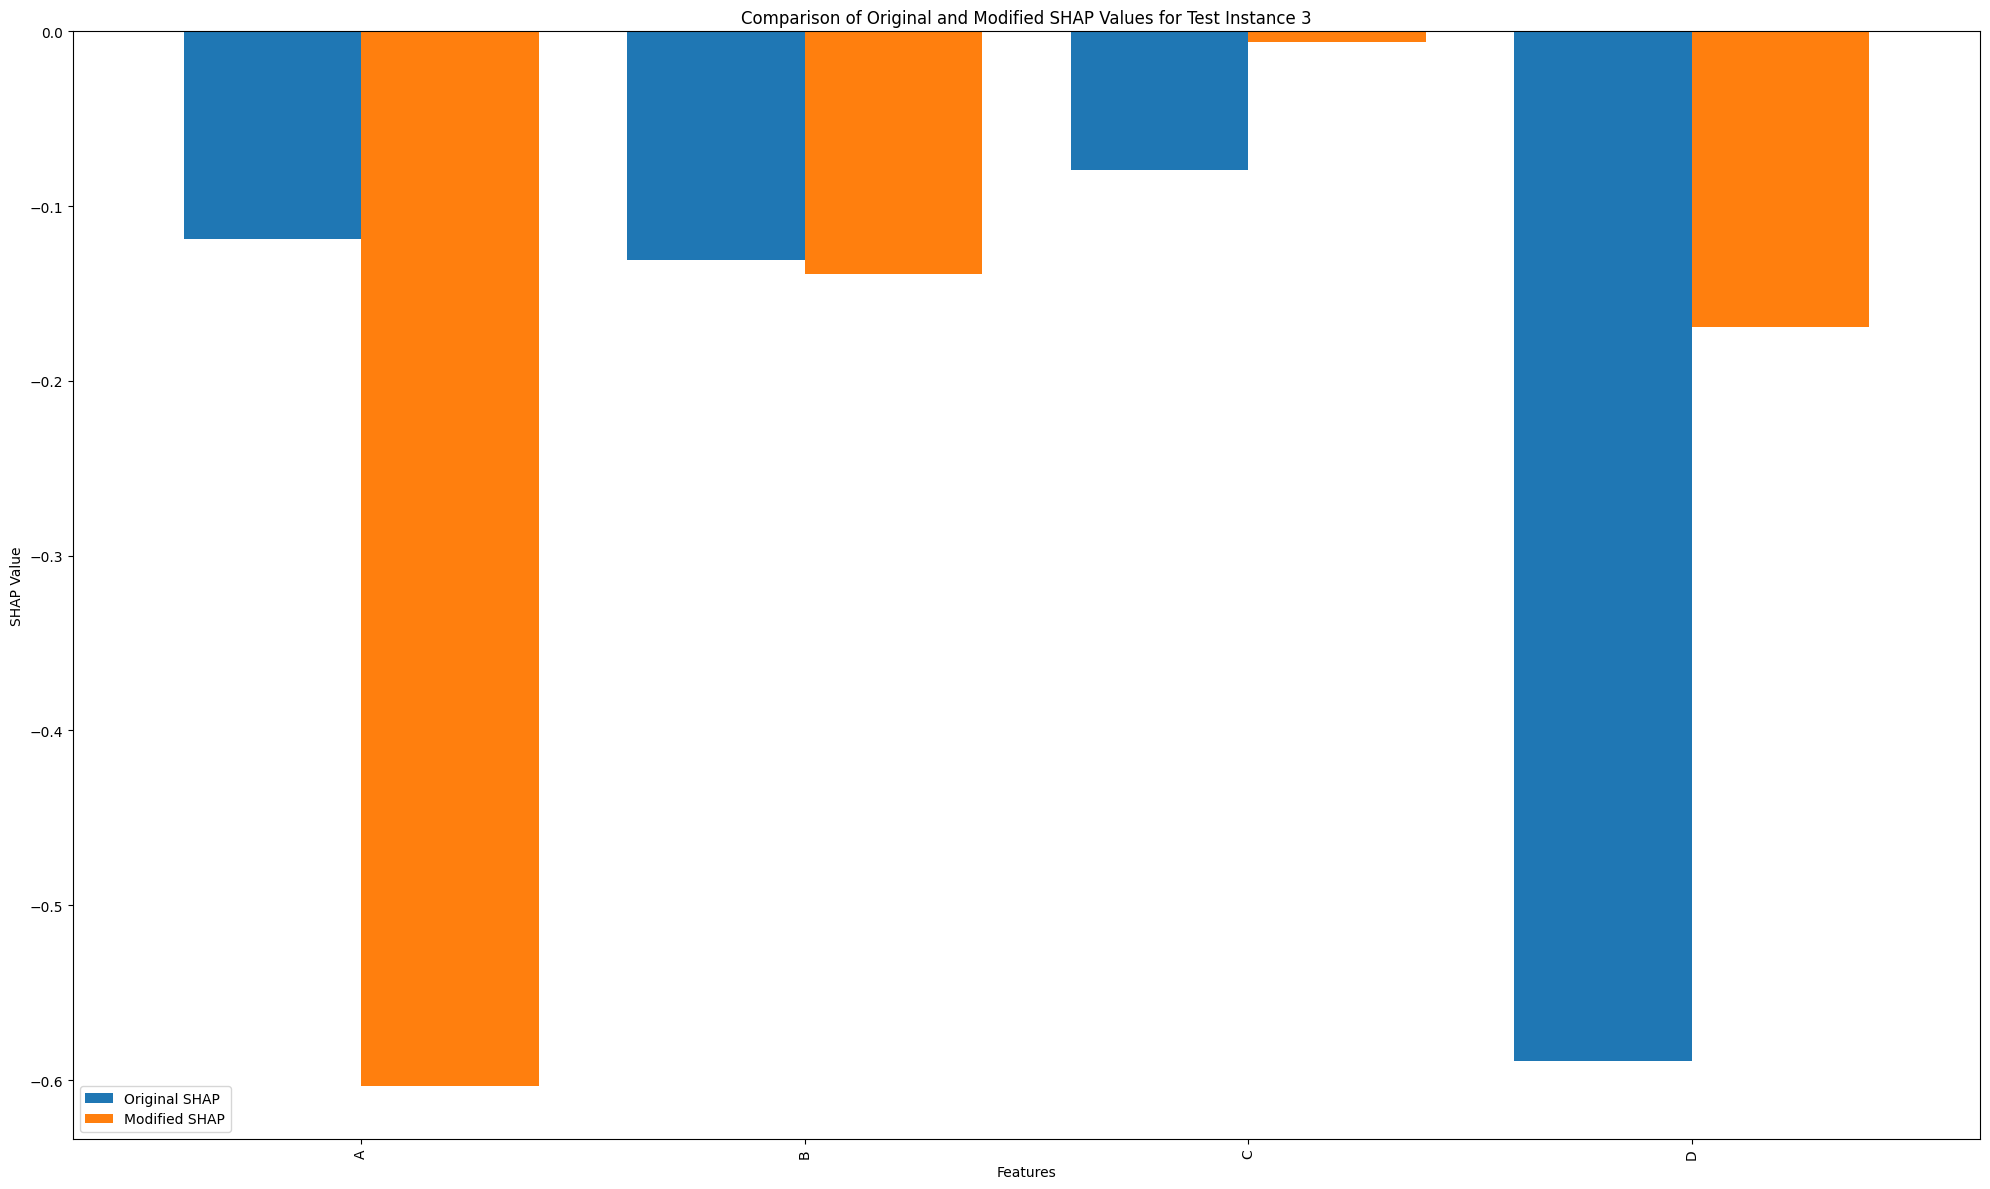

In [21]:
import matplotlib.pyplot as plt

# Extract the original SHAP values and modified SHAP values into a DataFrame
features = X_test_scaled_df.columns  # Feature names from the dataset
original_shap_values = pd.Series(shap_values[i], index=features)
modified_shap_values = pd.Series(phi_normalized, index=features)

# Combine both sets of values into a DataFrame for comparison
shap_comparison_df = pd.DataFrame({
    'Original SHAP': original_shap_values,
    'Modified SHAP': modified_shap_values
})

# Plot the comparison
plt.figure(figsize=(10, 6))
shap_comparison_df.plot(kind='bar', width=0.8)
plt.title(f"Comparison of Original and Modified SHAP Values for Test Instance {i}")
plt.xlabel("Features")
plt.ylabel("SHAP Value")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [8]:
# Precompute E[f(X)]
E_fX = ci.model.predict(ci.data[['A','B','C','D']]).mean()
print(f"Expected value for instance {i}: {E_fX}")

# Compute f(x)
f_x = ci.model.predict(x_instance.to_frame().T)[0]
print(f"Model prediction for test instance {i}: {f_x}")

# Sum of modified SHAP values
sum_phi_modified = sum(phi_normalized.values())
print(f"Sum of modified SHAP values: {sum_phi_modified}")
shap_sum = sum_phi_modified + E_fX
print(f"Sum of SHAP values + expected value for instance {i}: {shap_sum}")

# Check if they are approximately equal
if np.isclose(shap_sum, f_x, atol=1e-6):
    print("The sum of SHAP values and the expected value matches the model prediction.")
else:
    print("There is a discrepancy between the SHAP sum and the model prediction.")


Expected value for instance 1: 0.04556963385230069
Model prediction for test instance 1: 1.4845240312623518
Sum of modified SHAP values: 1.4389543974100512
Sum of SHAP values + expected value for instance 1: 1.4845240312623518
The sum of SHAP values and the expected value matches the model prediction.


In [9]:
print(f"i = {i}")
standard_shap_values = shap_values[i]
causal_shap_values = phi_normalized

# Convert to pandas Series for easier handling
standard_shap_series = pd.Series(standard_shap_values, index=X_test_scaled_df.columns)
causal_shap_series = pd.Series(causal_shap_values, index=X_test_scaled_df.columns)

# print(standard_shap_series)
# print(causal_shap_series)

# 5.1. Iterative Feature Deletion
avg_output_standard_deletion = iterative_feature_deletion_with_avg_output_regression(
    model=model,
    input_features=x_instance,
    attribution_scores=standard_shap_series,
    top_k=4  # All features
)

avg_output_causal_deletion = iterative_feature_deletion_with_avg_output_regression(
    model=model,
    input_features=x_instance,
    attribution_scores=causal_shap_series,
    top_k=4  # All features
)

print("\nIterative Feature Deletion: (Lower Score better)")
print(f"Average Output (Standard SHAP): {avg_output_standard_deletion}")
print(f"Average Output (Causal SHAP): {avg_output_causal_deletion}")

# 5.2. Iterative Feature Addition
avg_output_standard_addition = iterative_feature_addition_with_avg_output_regression(
    model=model,
    input_features=x_instance,
    attribution_scores=standard_shap_series,
    top_k=4  # All features
)

avg_output_causal_addition = iterative_feature_addition_with_avg_output_regression(
    model=model,
    input_features=x_instance,
    attribution_scores=causal_shap_series,
    top_k=4  # All features
)

print("\nIterative Feature Addition: (Higher Score better)")
print(f"Average Output (Standard SHAP): {avg_output_standard_addition}")
print(f"Average Output (Causal SHAP): {avg_output_causal_addition}")

i = 1

Iterative Feature Deletion: (Lower Score better)
Average Output (Standard SHAP): 0.35656693963456326
Average Output (Causal SHAP): 0.7747872036539756

Iterative Feature Addition: (Higher Score better)
Average Output (Standard SHAP): 1.3212087519808826
Average Output (Causal SHAP): 0.8824409060252407


##### Run for loop from i=0 to 49

In [10]:
# Precompute values that don't change across iterations

# Compute explainer expected value (if applicable)
explainer_expected_value = explainer.expected_value

# Ensure that y_test and y_train have a sequential index
y_test = y_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Combine features and target variable into one DataFrame
data_with_E = pd.concat([X_train_scaled_df, y_train], axis=1)
data_with_E = data_with_E.rename(columns={0: 'E'})

# Create an instance of CausalInference with preloaded causal strengths
ci = CausalInference(data=data_with_E, model=model, target_variable='E')

# Load causal strengths from JSON file once
ci.load_causal_strengths('../../../Result/R/Mean_Causal_Effect_Synthetic.json')

# Precompute E[f(X)] for the entire dataset
E_fX = ci.model.predict(ci.data[['A', 'B', 'C', 'D']]).mean()
print(f"Expected value for all instances: {E_fX}")

# Loop over instances
for i in range(50):  # Loop from 0 to 49
    print(f"i = {i}")
    x_instance = pd.Series(X_test_scaled_df.iloc[i], index=X_test_scaled_df.columns)
    phi_normalized = ci.compute_modified_shap(x_instance)

    standard_shap_values = shap_values[i]
    causal_shap_values = phi_normalized

    # Convert to pandas Series for easier handling
    standard_shap_series = pd.Series(standard_shap_values, index=X_test_scaled_df.columns)
    causal_shap_series = pd.Series(causal_shap_values, index=X_test_scaled_df.columns)

    # 5.1. Iterative Feature Deletion
    avg_output_standard_deletion = iterative_feature_deletion_with_avg_output_regression(
        model=model,
        input_features=x_instance,
        attribution_scores=standard_shap_series,
        top_k=4  # All features
    )

    avg_output_causal_deletion = iterative_feature_deletion_with_avg_output_regression(
        model=model,
        input_features=x_instance,
        attribution_scores=causal_shap_series,
        top_k=4  # All features
    )

    print("Iterative Feature Deletion: (Lower Score better)")
    print(f"Average Output (Standard SHAP): {avg_output_standard_deletion}")
    print(f"Average Output (Causal SHAP): {avg_output_causal_deletion}")

    # 5.2. Iterative Feature Addition
    avg_output_standard_addition = iterative_feature_addition_with_avg_output_regression(
        model=model,
        input_features=x_instance,
        attribution_scores=standard_shap_series,
        top_k=4  # All features
    )

    avg_output_causal_addition = iterative_feature_addition_with_avg_output_regression(
        model=model,
        input_features=x_instance,
        attribution_scores=causal_shap_series,
        top_k=4  # All features
    )

    print("\nIterative Feature Addition: (Higher Score better)")
    print(f"Average Output (Standard SHAP): {avg_output_standard_addition}")
    print(f"Average Output (Causal SHAP): {avg_output_causal_addition}\n")


Expected value for all instances: 0.04556963385230069
i = 0
Iterative Feature Deletion: (Lower Score better)
Average Output (Standard SHAP): 0.18942466720756418
Average Output (Causal SHAP): 0.43691925108164364

Iterative Feature Addition: (Higher Score better)
Average Output (Standard SHAP): 0.7248095624712413
Average Output (Causal SHAP): 0.478535781358057

i = 1
Iterative Feature Deletion: (Lower Score better)
Average Output (Standard SHAP): 0.35656693963456326
Average Output (Causal SHAP): 0.7747872036539756

Iterative Feature Addition: (Higher Score better)
Average Output (Standard SHAP): 1.3212087519808826
Average Output (Causal SHAP): 0.8824409060252407

i = 2
Iterative Feature Deletion: (Lower Score better)
Average Output (Standard SHAP): -0.5927992003847788
Average Output (Causal SHAP): -0.8088900675033663

Iterative Feature Addition: (Higher Score better)
Average Output (Standard SHAP): -1.2081494732635174
Average Output (Causal SHAP): -1.4242403403821051

i = 3
Iterative Fea

#### Summary
- The normalization of SHAP(i)_causal helps to the additivity feature compared to the original SHAP.
- In this case we see that the changes of Value function computation reduce the E_fX
- The reduction of E_fX has caused the SHAP(A)_causal to be significantly higher than SHAP(A)
- Which is a good thing because we has emphasized the importance of A -> E?

## Archive 
We will use R for PC

Depth=2, working on node 4: 100%|██████████| 5/5 [00:00<00:00, 343.29it/s]


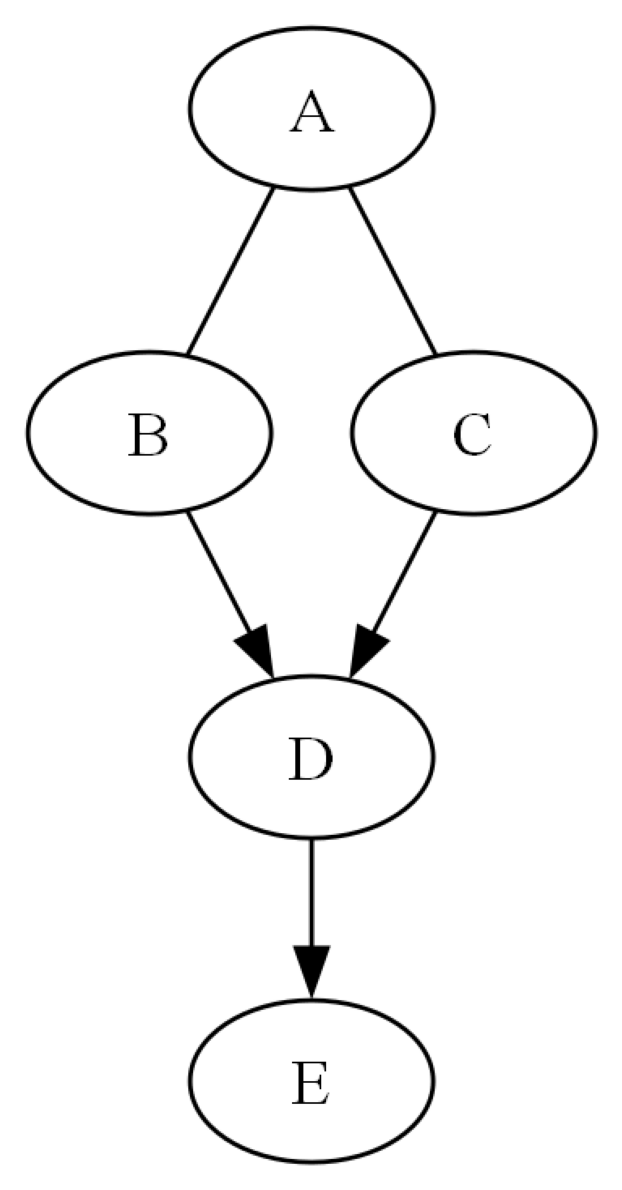

In [11]:
data_for_pc = data.to_numpy()
cg = pc(data_for_pc, alpha=0.05)
cg.draw_pydot_graph(labels=data.columns)

In [12]:
edges = cg.G.get_graph_edges()
feature_names = data.columns.tolist()
node_id_to_feature_name = {f'X{i+1}': name for i, name in enumerate(feature_names)}

endpoint_pairs_to_edge_type = {
    ('TAIL', 'ARROW'): '->',
    ('ARROW', 'TAIL'): '<-',
    ('ARROW', 'ARROW'): '<->',
    ('TAIL', 'TAIL'): '--',
    ('CIRCLE', 'ARROW'): 'o->',
    ('ARROW', 'CIRCLE'): '<-o',
    ('CIRCLE', 'TAIL'): 'o-',
    ('TAIL', 'CIRCLE'): '-o',
}

print("Edges in the causal graph:")
for edge in edges:
    from_node_id = edge.node1.get_name()
    to_node_id = edge.node2.get_name()
    from_node = node_id_to_feature_name[from_node_id]
    to_node = node_id_to_feature_name[to_node_id]
    endpoints = (edge.endpoint1.name, edge.endpoint2.name)
    edge_type = endpoint_pairs_to_edge_type.get(endpoints, f'{endpoints[0]}-{endpoints[1]}')
    print(f"{from_node} {edge_type} {to_node}")


Edges in the causal graph:
A -- B
A -- C
B -> D
C -> D
D -> E
